In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm

from sklearn.naive_bayes import GaussianNB

import xarrayaita.aita
import pickle

In [2]:
file = open('data/craft/CI02.xr', 'rb')
ds_CI02 = pickle.load(file)
file.close()

file = open('data/craft/CI04.xr', 'rb')
ds_CI04 = pickle.load(file)
file.close()

file = open('data/craft/CI06.xr', 'rb')
ds_CI06 = pickle.load(file)
file.close()

file = open('data/craft/CI09.xr', 'rb')
ds_CI09 = pickle.load(file)
file.close()

file = open('data/craft/CI21.xr', 'rb')
ds_CI21 = pickle.load(file)
file.close()

In [3]:
TJ_CI02 = utils.load_tj_data("data/TJ/TJ_CI02.npy")
TJ_CI04 = utils.load_tj_data("data/TJ/TJ_CI04.npy")
TJ_CI06 = utils.load_tj_data("data/TJ/TJ_CI06.npy")
TJ_CI09 = utils.load_tj_data("data/TJ/TJ_CI09.npy")
TJ_CI21 = utils.load_tj_data("data/TJ/TJ_CI21.npy")

tj_to_skip_CI02 = list(TJ_CI02.loc[(TJ_CI02.RX.isna())].index)
tj_to_skip_CI04 = list(TJ_CI04.loc[(TJ_CI04.RX.isna())].index)
tj_to_skip_CI06 = list(TJ_CI06.loc[(TJ_CI06.RX.isna())].index)
tj_to_skip_CI09 = list(TJ_CI09.loc[(TJ_CI09.RX.isna())].index)
tj_to_skip_CI21 = list(TJ_CI21.loc[(TJ_CI21.RX.isna())].index)

TJ_CI02 = TJ_CI02.dropna()
TJ_CI04 = TJ_CI04.dropna()
TJ_CI06 = TJ_CI06.dropna()
TJ_CI09 = TJ_CI09.dropna()
TJ_CI21 = TJ_CI21.dropna()

In [4]:
X1 = TJ_CI02.iloc[:,((TJ_CI02.columns != 'RX'))]
X2 = TJ_CI04.iloc[:,((TJ_CI04.columns != 'RX'))]
X3 = TJ_CI06.iloc[:,((TJ_CI06.columns != 'RX'))]
X4 = TJ_CI09.iloc[:,((TJ_CI09.columns != 'RX'))]
X5 = TJ_CI21.iloc[:,((TJ_CI21.columns != 'RX'))]

y1 = TJ_CI02.iloc[:, 0]
y2 = TJ_CI04.iloc[:, 0]
y3 = TJ_CI06.iloc[:, 0]
y4 = TJ_CI09.iloc[:, 0]
y5 = TJ_CI21.iloc[:, 0]

In [5]:
X_train = pd.concat((X1,X3,X4,X5))
y_train = pd.concat((y1,y3,y4,y5))

X_test = X2
y_test = y2

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
clf = GaussianNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

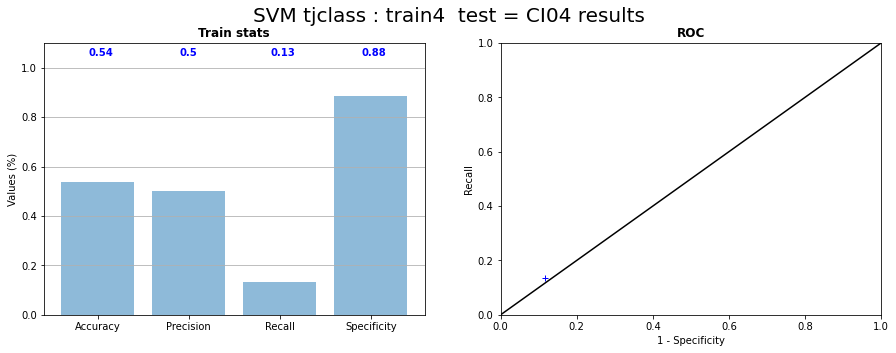

In [8]:
acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="SVM tjclass : train4  test = CI04")

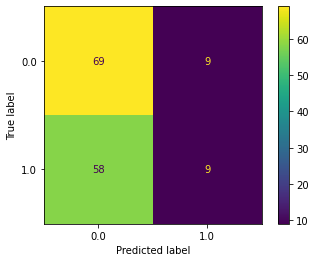

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)  
plt.show()

In [10]:
maps = ds_CI04.aita.dist2eachTJ()
imshape = np.shape(ds_CI04.grainId)
M = ds_CI04.aita.TJ_map()
coords = M.T[0:2]


In [11]:
tj_to_skip = tj_to_skip_CI04

In [12]:
tj_to_skip.reverse()
for i in tj_to_skip:
    coords = np.delete(coords,i,1)

In [13]:
from matplotlib import colors
col = -(y_pred+2*np.array(y_test))
cmap = colors.ListedColormap(['green','red','blue','gray'])
bounds=[-3.5,-2.5,-1.5,-0.5,0.5]
norm = colors.BoundaryNorm(bounds, cmap.N)



In [14]:
imshape

(554, 534)

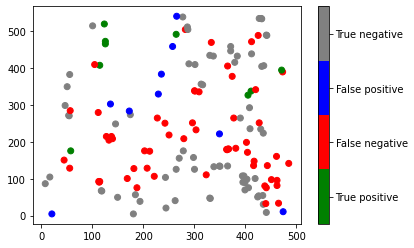

In [14]:
plot = plt.scatter(coords[0],coords[1],c=col,cmap=cmap,norm=norm)
cbar = plt.colorbar(plot, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-3, -2, -1,0])

cbar.set_ticklabels(["True positive","False negative","False positive","True negative"])

-------------------------------
# CV

In [15]:
names = ["TJ_CI02","TJ_CI04","TJ_CI06","TJ_CI09","TJ_CI21"]
vars = [X1,X2,X3,X4,X5]
group = [y1,y2,y3,y4,y5]

In [17]:
acc = []
prec = []
recall = []
specif = []

for i in range(len(vars)):
    ln = names.copy()
    ln.pop(i)
    lX = vars.copy()
    lX.pop(i)
    ly = group.copy()
    ly.pop(i)

    X_test = vars[i]
    y_test = group[i]

    for j in range(len(lX)):
        if j == 0:
            X_train = lX[j]
            y_train = ly[j]
        else:
            X_train = pd.concat([X_train,lX[j]])
            y_train = pd.concat([y_train,ly[j]])

    #print("Learning :\n \tTrain : ",ln,"\n \tTest : ",names[i])

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    clf = GaussianNB()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = metrics.confusion_matrix(y_test, y_pred)

    if (metrics.recall_score(y_test, y_pred) < (1-(cm[0,0] / (cm[0,0] + cm[0,1])))):
        y_pred = 1- y_pred
        cm = metrics.confusion_matrix(y_test, y_pred)

    acc.append(metrics.accuracy_score(y_test, y_pred))
    prec.append(metrics.precision_score(y_test, y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))
    specif.append(cm[0,0] / (cm[0,0] + cm[0,1]))

print("Learning done")

results = [acc,prec,recall,specif]

np.savetxt("../RUN_GRICAD/res/CV_TJ-GNB_res.txt",results)

Learning done


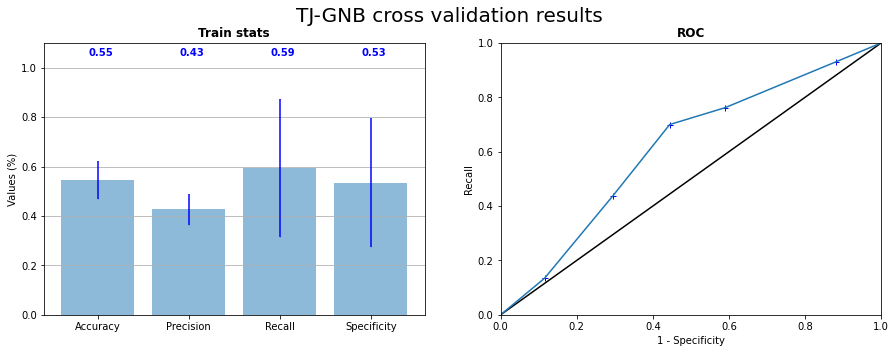

In [18]:
utils.plot_res_CV("../RUN_GRICAD/res/CV_TJ-GNB_res.txt")

(<Figure size 720x720 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC of models cross validation'}, xlabel='1 - Specificity', ylabel='Recall'>)

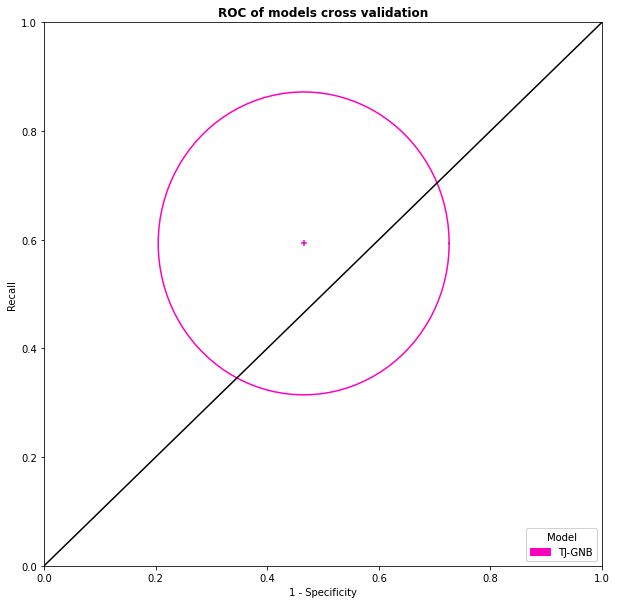

In [20]:
utils.ROC_patch(["../RUN_GRICAD/res/CV_TJ-GNB_res.txt"])